# Fine-tuning SpeechT5 for multilingual TTS

This notebook adapted from: https://colab.research.google.com/drive/1i7I5pzBcU3WDFarDnzweIj4-sVVoIUFJ

This notebook demonstrates how to fine-tune the SpeechT5 model from 🤗 Transformers on the **text-to-speech** task.

The unique thing about SpeechT5 is that the model is first pre-trained on a combination of speech-to-text and text-to-speech data, so that it learns a unified space of hidden representations shared by both text and speech. This allows us to fine-tune the same pretrained model on different tasks. Read more about SpeechT5 [in our blog post](https://huggingface.co/blog/speecht5).

In this notebook we will start from an existing fine-tuned TTS model that was originally trained on English speech from LibriTTS, and fine-tune it for the Dutch language using the VoxPopuli dataset.

This TTS model will support multiple speakers through x-vector speaker embeddings.

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again but for a new language. For more info about the original checkpoint, you can find its model card on the [Hugging Face Hub](https://huggingface.co/microsoft/speecht5_tts).

In [1]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/home/j/Documents/MLotsawa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-21 20:28:55.738168: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 20:28:55.748029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750552135.759830    7131 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750552135.763964    7131 cuda_blas.cc:140

In [2]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast.from_pretrained('billingsmoore/getok-v0')

In [3]:
processor.tokenizer = tokenizer

## Load the dataset

We'll fine-tune on the Dutch (language code `nl`) examples from VoxPopuli.

VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages.

You can find [VoxPopuli on the Hugging Face Hub](https://huggingface.co/datasets/facebook/voxpopuli). There, you can listen to audio samples in any one of the 15 European languages using the dataset previewer.

Note that VoxPopuli, or any other automatic speech recognition (ASR) dataset, is not necessarily the best dataset to use for TTS training. The qualities that make it useful for ASR, such as lots of noise in the sound, are usually what we want to avoid in TTS. But high-quality, multilingual, multi-speaker TTS datasets are less easy to find than ASR datasets.

In [4]:
from datasets import load_dataset, Audio

dataset = load_dataset('billingsmoore/tibetan-asr', split='train').select(range(5))

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [5]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Let's quickly check how many examples are in this dataset.

In [6]:
len(dataset)

5

That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [7]:
tokenizer = processor.tokenizer
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32000, 768, padding_idx=1)

In [8]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcription"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map: 100%|██████████| 5/5 [00:00<00:00, 1168.92 examples/s]


Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [9]:
dataset_vocab - tokenizer_vocab

{' '}

## Speakers

VoxPopuli is a multi-speaker dataset. We know there are 20968 examples in the dataset, but how many speakers are there and how many examples do they have?

In [10]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram we can get a sense of how much data there is for each speaker.

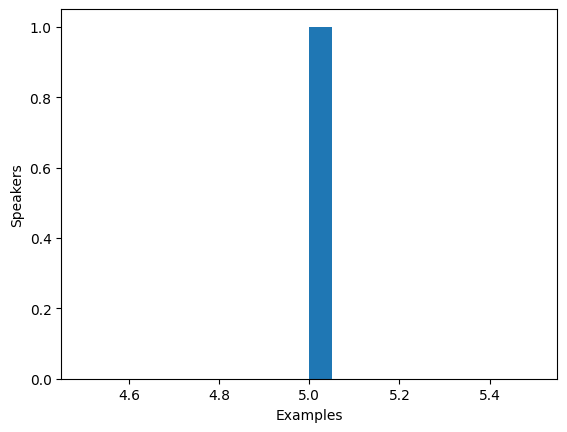

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [12]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

/tmp/ipykernel_7131/1262525938.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
/home/j/Documents/MLotsawa/.venv/lib/python3.10/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [13]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["transcription"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [14]:
processed_example = prepare_dataset(dataset[0])

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [15]:
list(processed_example.keys())

['input_ids', 'token_type_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [16]:
tokenizer.decode(processed_example["input_ids"])

'ཀྲུང་གོའི་ཐའེ་ཝན་ལའང་གློག་ཀླད་ནད་དུག་གིས་ཤུགས་རྐྱེན་ཆེན་པོ་ཐེབས་ཡོད།'

Speaker embeddings should be a 512-element vector:

In [17]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

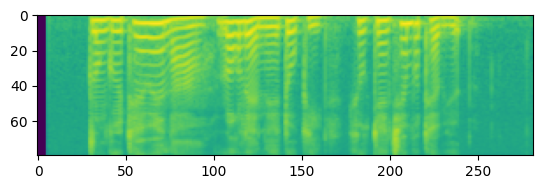

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [19]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [20]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [21]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

In [22]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [23]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

How many examples are left?

In [24]:
len(dataset)

5

## Train/test split

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [25]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'labels', 'speaker_embeddings'],
        num_rows: 4
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'labels', 'speaker_embeddings'],
        num_rows: 1
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [26]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch
    
data_collator = TTSDataCollatorWithPadding(processor=processor)

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

## Training

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [27]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

In [28]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=100,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=50,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

trainer.train()

/tmp/ipykernel_7131/2635519999.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,0.791100,1.292505
100,0.494700,0.967275


/home/j/Documents/MLotsawa/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:3567: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


KeyboardInterrupt: 

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("Matthijs/speecht5_tts_voxpopuli_nl")

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

Define some input text and tokenize it.

In [ ]:
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

## Building a demo

To showcase your newly fine-tuned model, make a demo on Hugging Face Spaces! We've created a [template Gradio demo](https://huggingface.co/spaces/Matthijs/speecht5-tts-demo) that you can easily copy and make your own.

Click the link to duplicate the template demo to your account: https://huggingface.co/spaces/Matthijs/speecht5-tts-demo?duplicate=true (or from the three-dot button at the top choose **Duplicate this Space**).

We recommend giving your space a similar name to your fine-tuned model (e.g. `speecht5_tts_voxpopuli_nl`) and setting the visibility to "Public".

Once you've duplicated the Space to your account, click **Files and versions > app.py > edit**. Change the model identifier to your fine-tuned model (line 9). Scroll to the bottom of the page and click **Commit changes to main**. The demo will reboot, this time using your fine-tuned model.

You can share this demo with your friends and family so that they can use the model that you've trained!